Architecture was taken from https://github.com/ozanciga/gans-with-pytorch <br>
UPD: corrected loss function as was mentioned <a href="https://www.kaggle.com/c/generative-dog-images/discussion/99485#latest-573753">here<a/>

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [2]:
!pip install --upgrade ipywidgets

     |████████████████████████████████| 133kB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 51.9MB/s eta 0:00:01
     |████████████████████████████████| 256kB 55.0MB/s eta 0:00:01
  Found existing installation: widgetsnbextension 3.4.2
    Uninstalling widgetsnbextension-3.4.2:
      Successfully uninstalled widgetsnbextension-3.4.2
  Found existing installation: ipywidgets 7.4.2
    Uninstalling ipywidgets-7.4.2:
      Successfully uninstalled ipywidgets-7.4.2


# Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

## Parameters of GAN

In [4]:
batch_size = 32
lr = 0.001
beta1 = 0.5
epochs = 500

real_label = 0.5
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader and Augmentations

In [5]:
import os
import shutil

def move_images(source_dir, target_dir, limit=3000):
    # Check if target directory exists, if not, create it
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Counter for the number of moved images
    moved_count = 0

    # List of files to exclude
    excluded_files = ['10.jpg', '7.jpg']

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Check if the file is an image and not in the excluded list
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) and file not in excluded_files:
                # Construct full file path
                file_path = os.path.join(root, file)
                
                # Construct the path where the image will be moved
                target_path = os.path.join(target_dir, file)
                
                # Move the image
                shutil.copy(file_path, target_path)
                print(f"Moved: {file_path} -> {target_path}")
                
                # Increment the counter
                moved_count += 1
                
                # Stop after moving the first 'limit' images
                if moved_count >= limit:
                    print(f"Reached the limit of {limit} images.")
                    return

# Set the source directory and the target directory
source_directory = "/kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square"  # Replace with the actual path
target_directory = "/kaggle/working/allimages/shoes"  # Replace with the target folder path

# Move the first 100 images, excluding 10.jpg and 7.jpg
move_images(source_directory, target_directory, limit=4000)

Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Nike/7525639.191707.jpg -> /kaggle/working/allimages/shoes/7525639.191707.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Nike/7525639.151.jpg -> /kaggle/working/allimages/shoes/7525639.151.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Teva Kids/7592562.275.jpg -> /kaggle/working/allimages/shoes/7592562.275.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Keen Kids/7501314.4535.jpg -> /kaggle/working/allimages/shoes/7501314.4535.jpg
Moved: /kaggle/input/large-shoe-dataset-ut-zappos50k/ut-zap50k-images-square/ut-zap50k-images-square/Sandals/Athletic/Keen Kids/7397030.4535.jpg -> /kaggle/working/allimages/shoes/7397030.4535.jpg
Moved: /kaggle/input/larg

In [6]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [7]:
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = CustomDataset(img_dir='/kaggle/working/allimages/shoes',
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

                                           
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Let's see examples of traing data

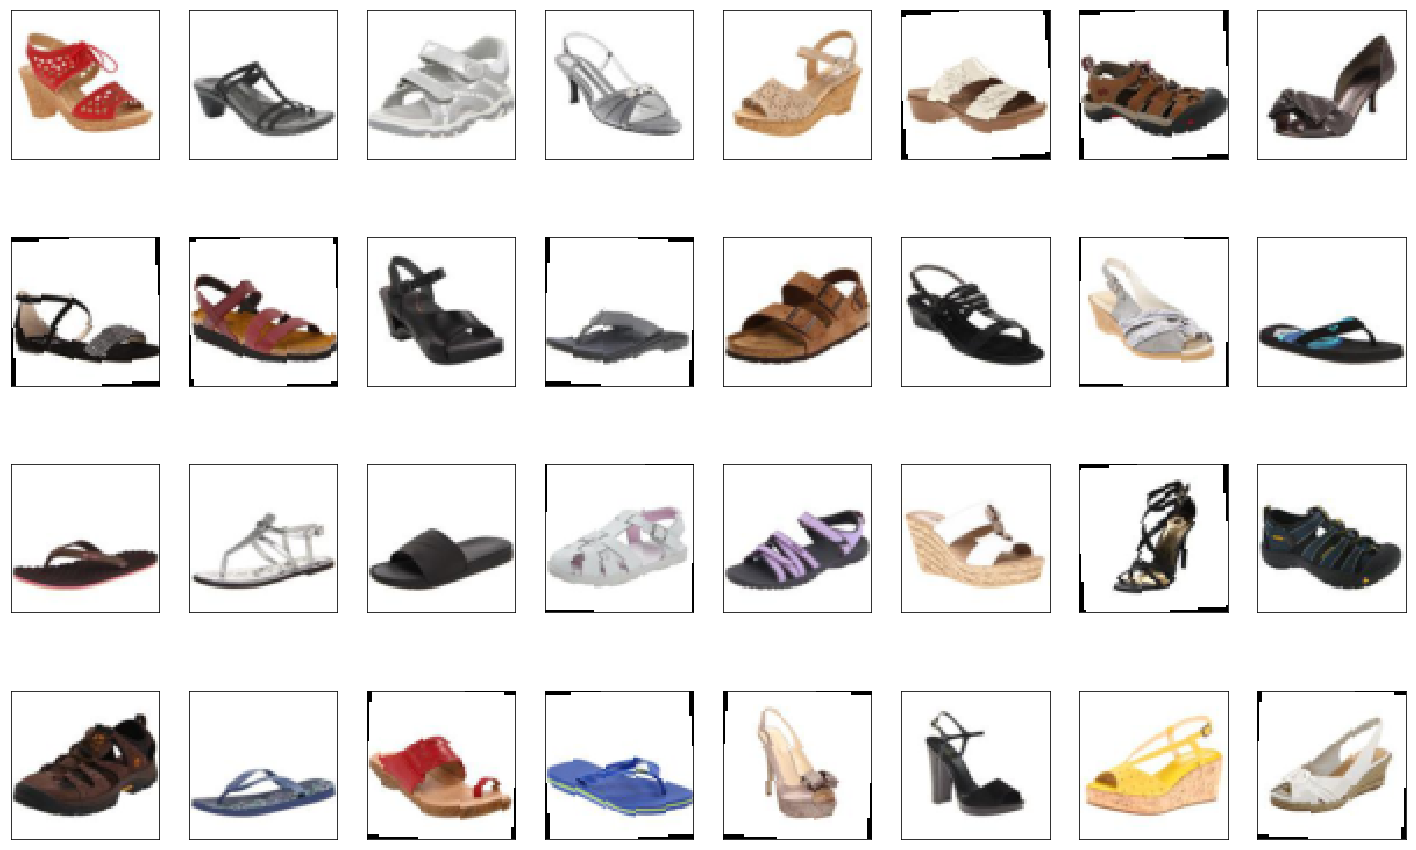

In [8]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

## Initialize models and optimizers

In [9]:
from torchvision.models import alexnet
netD = alexnet(pretrained=True)
netD.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=1, bias=True),
    nn.Sigmoid()
  )
netD.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:01<00:00, 150691037.31it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [10]:
for name, param in netD.named_parameters():
    if param.requires_grad:
        param.requires_grad = False

In [11]:
for name, param in netD.classifier.named_parameters():
    if ('4' in name) or ('6' in name):
        param.requires_grad = True

In [12]:
len([p for p in netD.parameters() if p.requires_grad])

4

In [13]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

non_frozen_parameters = [p for p in netD.parameters() if p.requires_grad]
optimizerD = optim.Adam(non_frozen_parameters, lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [14]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [15]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

## Training loop

 52%|█████▏    | 65/125 [00:03<00:02, 20.85it/s]

[1/500] [62/125] Loss_D: 0.4756 Loss_G: 1.0176


100%|██████████| 125/125 [00:06<00:00, 20.89it/s]


[1/500] [124/125] Loss_D: 0.2196 Loss_G: 1.5694


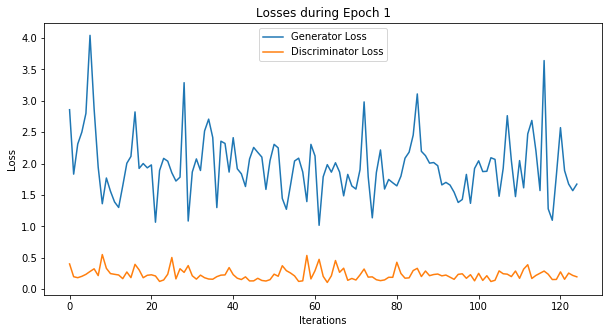

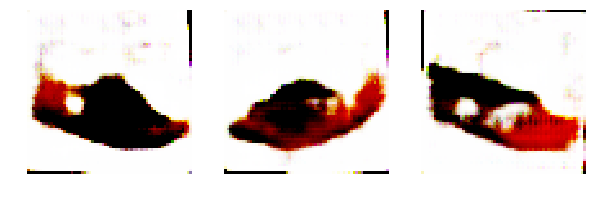

Epoch 1/500 completed in 6.68 seconds


 52%|█████▏    | 65/125 [00:03<00:02, 20.76it/s]

[2/500] [62/125] Loss_D: 0.4395 Loss_G: 2.2070


100%|██████████| 125/125 [00:06<00:00, 20.83it/s]

[2/500] [124/125] Loss_D: 0.2311 Loss_G: 1.5071
Epoch 2/500 completed in 6.16 seconds



 52%|█████▏    | 65/125 [00:03<00:02, 20.84it/s]

[3/500] [62/125] Loss_D: 0.1512 Loss_G: 1.9624


100%|██████████| 125/125 [00:06<00:00, 20.89it/s]

[3/500] [124/125] Loss_D: 0.1400 Loss_G: 2.1306
Epoch 3/500 completed in 6.16 seconds



 52%|█████▏    | 65/125 [00:03<00:02, 20.75it/s]

[4/500] [62/125] Loss_D: 0.2130 Loss_G: 2.9774


100%|██████████| 125/125 [00:06<00:00, 20.84it/s]

[4/500] [124/125] Loss_D: 0.2609 Loss_G: 2.1878
Epoch 4/500 completed in 6.17 seconds



 52%|█████▏    | 65/125 [00:03<00:02, 20.81it/s]

[5/500] [62/125] Loss_D: 0.2499 Loss_G: 2.9743


100%|██████████| 125/125 [00:06<00:00, 20.84it/s]

[5/500] [124/125] Loss_D: 0.2013 Loss_G: 2.1954
Epoch 5/500 completed in 6.17 seconds



 52%|█████▏    | 65/125 [00:03<00:02, 20.83it/s]

[6/500] [62/125] Loss_D: 0.2981 Loss_G: 2.0742


100%|██████████| 125/125 [00:06<00:00, 20.89it/s]

[6/500] [124/125] Loss_D: 0.2931 Loss_G: 1.8170
Epoch 6/500 completed in 6.18 seconds



 52%|█████▏    | 65/125 [00:03<00:02, 20.85it/s]

[7/500] [62/125] Loss_D: 0.2903 Loss_G: 2.2397


100%|██████████| 125/125 [00:06<00:00, 20.86it/s]


[7/500] [124/125] Loss_D: 0.3134 Loss_G: 1.6957
Model converged after 7 epochs


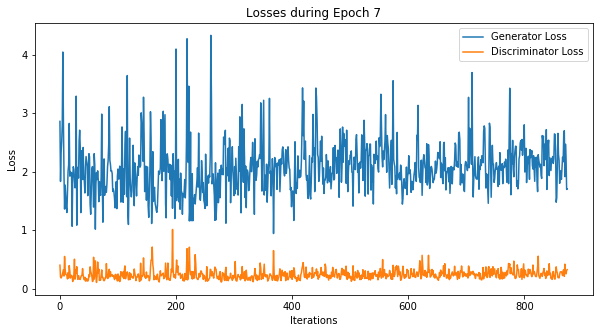

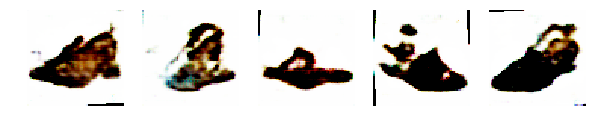

The model has likely converged.
Total epochs trained: 7


In [17]:
import time
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# Lists to store losses for plotting later
G_losses = []
D_losses = []

# Hyperparameters for regularization and early stopping
dropout_prob = 0.3  # Dropout probability
l2_lambda = 1e-4  # L2 regularization strength (weight decay)
convergence_threshold = 0.01  # Convergence check threshold (loss change)
patience = 5  # Number of epochs to wait for improvement (early stopping)
no_improvement_count = 0  # Counter for early stopping

# Add Dropout to the networks (assuming you've defined your networks with Dropout layers)
# Example: netD and netG should include Dropout layers in their architecture

# Training loop
for epoch in range(epochs):
    start = time.time()
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        
        # Real images
        outputR = netD(real_images)
        
        # Fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        
        # Discriminator loss
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        
        # L2 Regularization (weight decay) for discriminator
        for param in netD.parameters():
            errD += l2_lambda * torch.sum(param ** 2)
        
        optimizerD.step()
        
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        outputF = netD(fake)  # Discriminator output for fake images
        
        # Generator loss
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        
        # L2 Regularization (weight decay) for generator
        for param in netG.parameters():
            errG += l2_lambda * torch.sum(param ** 2)
        
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Print losses every half epoch
        if (ii + 1) % (len(train_loader)//2) == 0:
            print(f'[{epoch+1}/{epochs}] [{ii+1}/{len(train_loader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')
    
    # Check for convergence and overfitting
    if epoch > 0:
        if abs(G_losses[-1] - G_losses[-2]) < convergence_threshold:
            print(f"Model converged after {epoch+1} epochs")
            break  # Stop training if model has converged

    # Early stopping if no improvement in generator loss
    if epoch > 0 and abs(G_losses[-1] - G_losses[-2]) < convergence_threshold:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in loss")
            break
    else:
        no_improvement_count = 0  # Reset the counter if there was improvement

    # Plot losses and generated images after every 10 epochs
    if epoch % 10 == 0:
        plot_loss(G_losses, D_losses, epoch)
        show_generated_img(3)  # Function to display generated images

    epoch_time = time.time() - start
    print(f'Epoch {epoch+1}/{epochs} completed in {epoch_time:.2f} seconds')

# Function to plot losses
def plot_loss(G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title(f'Losses during Epoch {epoch+1}')
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to display generated images (you need to define this function based on your setup)
def show_generated_img(num_images=3):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    fake_images = netG(noise)
    fake_images = fake_images.cpu().detach().numpy()
    
    fig, axs = plt.subplots(1, num_images, figsize=(10, 5))
    for i in range(num_images):
        axs[i].imshow(fake_images[i].transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

# After training ends, evaluate final results (plot losses, generated images)
plot_loss(G_losses, D_losses, epoch)
show_generated_img(5)  # Display some generated images at the end

# Model Evaluation
def evaluate_model():
    # Evaluate convergence based on loss trends
    if abs(G_losses[-1] - G_losses[-2]) < convergence_threshold:
        print("The model has likely converged.")
    else:
        print("The model has not converged yet.")
    
    # Check if overfitting occurs: 
    # If discriminator loss is very low and generator loss is high, it's overfitting
    if D_losses[-1] < 0.1 and G_losses[-1] > 1:
        print("Model is likely overfitting. Consider regularization techniques such as dropout, L2 regularization, or early stopping.")
    
    # Check if underfitting occurs: 
    # If the losses are high and not decreasing, it may be underfitting.
    if D_losses[-1] > 1 and G_losses[-1] > 1:
        print("Model is likely underfitting. Consider increasing model capacity or training for more epochs.")
        
    # Output the total number of epochs
    print(f"Total epochs trained: {epoch+1}")

# Call the evaluation function at the end
evaluate_model()


## Let's visualise generated results 

In [19]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

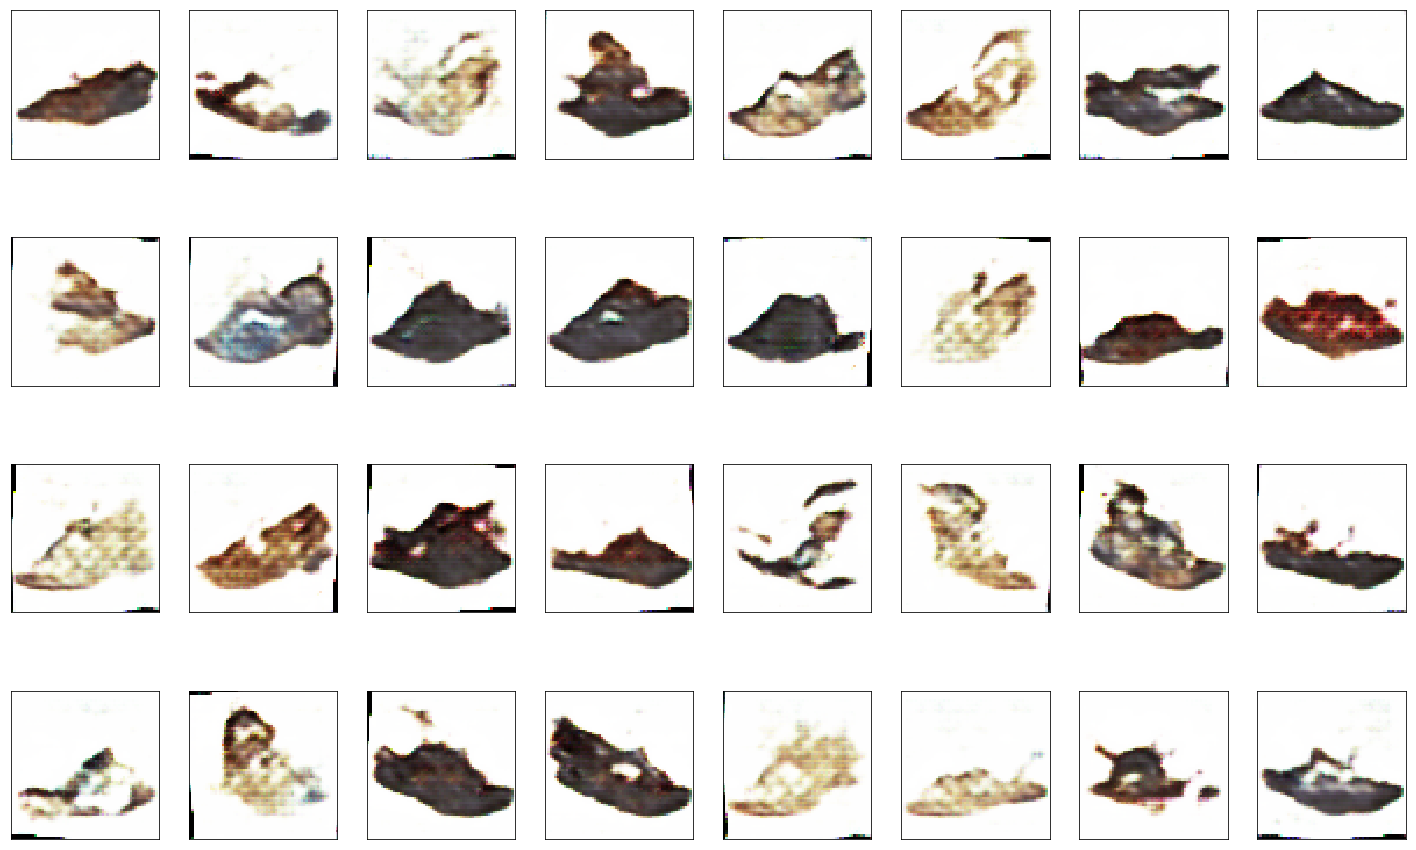

In [20]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

## Make predictions and submit

In [21]:
# import matplotlib.pyplot as plt

# def evaluate_model_performance(train_losses, val_losses, train_accuracies, val_accuracies, max_epochs):
#     # 1. Plot training and validation losses
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss')
#     plt.plot(range(1, max_epochs + 1), val_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()

#     # 2. Plot training and validation accuracies
#     plt.subplot(1, 2, 2)
#     plt.plot(range(1, max_epochs + 1), train_accuracies, label='Training Accuracy')
#     plt.plot(range(1, max_epochs + 1), val_accuracies, label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

#     # 3. Convergence check (if loss has stabilized)
#     if val_losses[-1] < val_losses[0] * 0.1:  # A simple condition for convergence
#         print("Model has converged.")
#     else:
#         print("Model has not fully converged.")

#     # 4. Check for overfitting or underfitting
#     if train_losses[-1] < val_losses[-1] and train_accuracies[-1] > val_accuracies[-1]:
#         print("Model is likely overfitting. Consider using regularization, dropout, or early stopping.")
#     elif train_losses[-1] > val_losses[-1] and train_accuracies[-1] < val_accuracies[-1]:
#         print("Model is underfitting. Consider using a more complex model, more epochs, or better features.")
#     else:
#         print("Model appears to be balanced, no immediate signs of overfitting or underfitting.")

#     # 5. How many epochs required for convergence (early stopping)
#     epoch_for_convergence = len([x for x in range(1, len(val_losses)) if val_losses[x] <= val_losses[x - 1]])
#     print(f"Model converged after {epoch_for_convergence} epochs.")

# # # Example usage
# # train_losses = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]  # Example training losses
# # val_losses = [1.0, 0.9, 0.85, 0.8, 0.75, 0.74]  # Example validation losses
# # train_accuracies = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8]  # Example training accuracies
# # val_accuracies = [0.45, 0.55, 0.6, 0.65, 0.7, 0.75]  # Example validation accuracies
# # max_epochs = 6  # Total number of epochs

# evaluate_model_performance(train_losses, val_losses, train_accuracies, val_accuracies, max_epochs)
